# Schleswig-Holstein

Every federal state is represented by its own input directory and is processed into a NUTS level 2 directory containing a sub-folder for each discharge location. These folder names are derived from NUTS and reflect the CAMELS id. The NUTS level 2 code for Schleswig Holstein is `DEF`.

To pre-process the data, you need to write (at least) two functions. One should extract all metadata and condense it into a single `pandas.DataFrame`. This is used to build the folder structure and derive the ids.
The second function has to take an id, as provided by the state authorities, called `provider_id` and return a `pandas.DataFrame` with the transformed data. The dataframe needs the three columns `['date', 'q' | 'w', 'flag']`.

For easier and unified output handling, the `camelsp` package contains a context object called `Bundesland`. It takes a number of names and abbreviations to identify the correct federal state and returns an object that holds helper and save functions.

The context saves files as needed and can easily be changed to save files with different strategies, ie. fill missing data with NaN, merge data into a single file, create files for each variable or pack everything together into a netcdf.

In [1]:
import pandas as pd
import numpy as np
import os
from tqdm import tqdm
from typing import Union, Dict, Tuple
import warnings
from math import radians, sin, atan2, cos, sqrt

from camelsp import Bundesland

The context can also be instantiated as any regular Python class, ie. to load only the default input data path, that we will user later.

In [2]:
# the context also makes the input path available, if camelsp was install locally
BASE = Bundesland('Schleswig-Holstein').input_path
BASE

'/home/camel/camelsp/input_data/Q_and_W/SH_Schleswig-Holstein'

## Parse metadata

Pegel metadata can be read quite easily. Only the separator is important as we have whitespaces in `'Gewässer'`

In [3]:
with Bundesland('Schleswig-Holstein') as bl:
    metadata = pd.read_csv(os.path.join(bl.input_path, 'gauge_attributes.csv'), encoding='latin1')

metadata

,id,gauge,river,area,x,y,watlevel_period,discharge_period,status,lon,lat
0,114001,Achterwehr,Eider,269.000,32562584,6019011,01.11.1984-21.03.2022,-999,inBetrieb,9.962054,54.315131
1,114450,Achtrupfeld,Brebek,26.550,32503881,6069898,08.11.2001-12.04.2022,08.11.2001-01.03.2022,inBetrieb,9.060335,54.776278
2,110034,Adamsiel,Nordsee,-999.000,32478768,6025071,01.03.1979-01.01.2003,-999,stillgelegtruht,8.673163,54.372988
3,111096,AdenbüllerKoog,NaN,-999.000,32491930,6023940,13.06.2005-02.09.2007,-999,stillgelegtruht,8.875803,54.363202
4,111105,AdenbüllerSielOW,TetenbüllspiekerKanal,12.985,32490061,6025357,29.01.2013-01.09.2018,-999,inBetrieb,8.846992,54.375904
...,...,...,...,...,...,...,...,...,...,...,...
770,114265,Wulfsdorf,HagenerAu,76.800,32584558,6022619,01.11.1985-01.05.1997,-999,stillgelegtruht,10.300781,54.344383
771,114103,Wulksfelde,Alster,139.120,32573621,5952781,01.11.1984-24.04.2022,01.11.1984-06.01.2022,inBetrieb,10.115643,53.718505
772,110005,WykFoehr,Nordsee,-999.000,32472688,6060763,01.11.1950-24.04.2022,-999,inBetrieb,8.576263,54.693458
773,114151,Zarpen,Heilsau,49.600,32600025,5970053,01.11.1984-24.04.2022,01.11.1984-15.03.2022,inBetrieb,10.521238,53.869303


In [4]:
# The id_column is id.
id_column = 'id'

# Stations without data
There are a lot of stations in the metadata for which we do not have datafiles.  
We delete these stations from the metadata.   

In [5]:
no_data_ids = ['110034', '114003', '110126', '110110', '110109', '114483',
               '114495', '110144', '114143', '114634', '114077', '110060',
               '110135', '110178', '110008', '110114', '110020', '114492',
               '114511', '114496', '114017', '110027', '110141', '110159',
               '114467', '114475', '110054', '110153', '110014', '110143',
               '114635', '114512', '114624', '110013', '110147', '110185',
               '110112', '110111', '110021', '110200', '110052', '114499',
               '114149', '114147', '114633', '114476', '114480', '110137',
               '114468', '111089', '111088', '110032', '110132', '114083',
               '114513', '114646', '114647', '114655', '114654', '114033',
               '114497', '114556', '114477', '110062', '114123', '114546',
               '114498', '110024', '110124', '110048', '110002', '110003',
               '110155', '110061', '110152', '110171', '110037', '114183',
               '110040', '110122', '114504', '111090', '111092', '110119',
               '111091', '110006', '110030', '110134', '110173', '110031',
               '110123', '110105', '110125', '110161', '110045', '110049',
               '114037', '110166', '114560', '114484', '110148', '114039',
               '114305', '110163', '110022', '110028', '114478', '114090',
               '114514', '110145', '110195', '110068', '110073', '114470',
               '110136', '110201', '110202', '110149', '110165', '110193',
               '111085', '110118', '114485', '110116', '110183', '110174',
               '110199', '110156', '110063', '110158', '110157', '110175',
               '110071', '110042', '110055', '111084', '111094', '110041',
               '114486', '110026', '114650', '111114', '110170', '114471',
               '114648', '110117', '110187', '110138', '110139', '114493',
               '110035', '114472', '110190', '111095', '110186', '110051',
               '110046', '114487', '114565', '110196', '110069', '110120',
               '110176', '110167', '110019', '110127', '110113', '110150',
               '110151', '110029', '111093', '110033', '110154', '110103',
               '114088', '110101', '110203', '110192', '110164', '114500',
               '114651', '110160', '110009', '110197', '110072', '110067',
               '114378', '114649', '110188', '110198', '114144', '110128',
               '110050', '110044', '114653', '114652', '114057', '110036',
               '110056', '110108', '110107', '110142', '110140', '112255',
               '112254', '110191', '114506', '110106', '110007', '114501',
               '114098', '114489', '114473', '114474', '114137', '114227',
               '110043', '110025', '110184', '114219', '114363', '110064',
               '110204', '110133', '110168', '110169', '110074', '110065',
               '110066', '110038', '110100', '110010', '110177', '110102',
               '110012', '110179', '110047', '110121', '110104', '110130',
               '110004', '114490', '114491', '110180', '110015', '111087',
               '111086', '110023', '110181', '110016', '110146', '110129',
               '114482', '114494', '114072', '110189', '110182', '110172',
               '110001', '110039', '110162', '114509', '114502', '110017',
               '114104', '110005']

metadata = metadata[~metadata['id'].astype(str).isin(no_data_ids)].reset_index(drop=True)
metadata

,id,gauge,river,area,x,y,watlevel_period,discharge_period,status,lon,lat
0,114001,Achterwehr,Eider,269.000,32562584,6019011,01.11.1984-21.03.2022,-999,inBetrieb,9.962054,54.315131
1,114450,Achtrupfeld,Brebek,26.550,32503881,6069898,08.11.2001-12.04.2022,08.11.2001-01.03.2022,inBetrieb,9.060335,54.776278
2,111096,AdenbüllerKoog,NaN,-999.000,32491930,6023940,13.06.2005-02.09.2007,-999,stillgelegtruht,8.875803,54.363202
3,111105,AdenbüllerSielOW,TetenbüllspiekerKanal,12.985,32490061,6025357,29.01.2013-01.09.2018,-999,inBetrieb,8.846992,54.375904
4,111106,AdenbüllerSielUW,TetenbüllspiekerKanal,12.985,32490058,6025380,29.01.2013-09.08.2018,-999,inBetrieb,8.846945,54.376110
...,...,...,...,...,...,...,...,...,...,...,...
504,114134,Wrist,Bramau,471.000,32549021,5976008,01.11.1984-24.04.2022,01.11.1984-01.07.1991,inBetrieb,9.746604,53.930147
505,114265,Wulfsdorf,HagenerAu,76.800,32584558,6022619,01.11.1985-01.05.1997,-999,stillgelegtruht,10.300781,54.344383
506,114103,Wulksfelde,Alster,139.120,32573621,5952781,01.11.1984-24.04.2022,01.11.1984-06.01.2022,inBetrieb,10.115643,53.718505
507,114151,Zarpen,Heilsau,49.600,32600025,5970053,01.11.1984-24.04.2022,01.11.1984-15.03.2022,inBetrieb,10.521238,53.869303


## Read all raw data

flag != 0 & flag < 120 & ~flag.isna() heißt geprüft

In [6]:
df_whole = pd.read_csv(os.path.join(BASE, 'thy_wst_abfluss_export.zip'),sep=';',encoding='latin1')#with pandas >2.0  just use: ,parse_dates=[2] date_format="%Y-%m-%d %H:%M:%S"
df_whole['datum'] = pd.to_datetime(df_whole['datum'])
df_whole

,sta_no_s,datum,wst,abfluss,abfluss_status,wst_status
0,114519,2012-01-10,171,21.3252,0.0,0
1,114519,2012-01-11,171,20.8745,0.0,0
2,114519,2012-01-12,170,20.9328,0.0,0
3,114519,2012-01-13,169,20.9042,0.0,0
4,114519,2012-01-14,168,20.1725,0.0,0
...,...,...,...,...,...,...
3746372,111035,2022-05-09,340,NaN,NaN,110
3746373,111035,2022-05-10,341,NaN,NaN,110
3746374,111035,2022-05-11,342,NaN,NaN,110
3746375,111035,2022-05-12,339,NaN,NaN,110


## Load Data

Loading data is a bit more complicated. There is an extra header, but that is not important. Only the 'Einhait' contains important information, but that has been added manually to the metadata.

In [7]:
#FALSE we only have Q, so remove variable from args
# We only have Q scraped so far, W will be added soon /msp
def extract_file(nr: Union[str, int], variable: str, base_path: str) -> Tuple[Dict[str, str], pd.DataFrame]:
    # always use str ids
    nr = str(nr)
    # merge the nr
    if '.' in nr:
        nr = nr.replace('.', '')

    # build the path
    assert variable in ['w','q','W','Q']
    
    
    path = os.path.join(base_path, variable.upper() , f'{nr}.csv')

    # return empty dataframe if data does not exist
    if not os.path.exists(path):
        return pd.DataFrame(columns=['date', variable.lower(), 'flag'])
    
    # otherwise read
    df = pd.read_csv(path, encoding="latin1", sep=";", decimal=",", parse_dates=[0], dayfirst=True)
    
    df.columns = ['date', variable.lower(), 'flag']
    df[variable.lower()] = df[variable.lower()].astype(float)

    # check if there are any values at all
    if df[variable.lower()].isna().all():
        return pd.DataFrame(columns=['date', 'q', 'flag'])
    
    # build the flag column
    df['flag'] = df.flag.apply(lambda f: f.lower() == 'qualitätsgesichert')

    return df

df = extract_file(114614,'q', BASE)

In [11]:
def extract_file_sh(nr: int) -> Tuple[pd.DataFrame, pd.DataFrame]:
    df_temp = df_whole[df_whole['sta_no_s'] == nr].drop(['sta_no_s'],axis=1)
    df_temp.columns = ['date','w','q','q_flag','w_flag']

    df_temp = df_temp.sort_values(by='date')
    df_temp = df_temp.reset_index(drop=True)

    # make sure the flags are boolean
    df_temp['q_flag'] = df_temp['q_flag'].astype(bool)
    df_temp['w_flag'] = df_temp['w_flag'].astype(bool)

    # alle Status-Werte kleiner 120 gelten als qualitätsgesichert.
    for flag in ['w_flag','q_flag']:
        # This is kinda clumsy, but I didn't want to set NaN flags with False, since they only occur when there is no measurement
        df_temp.loc[(df_temp[flag] < 120) & (~df_temp[flag].isna()),flag] = True
        df_temp.loc[(df_temp[flag] >= 120) & (~df_temp[flag].isna()),flag] = False

    df_q = pd.DataFrame(columns=['date', 'q', 'flag']) if df_temp['q'].isna().all() else df_temp[['date','q','q_flag']].rename({'q_flag':'flag'})
    df_w = pd.DataFrame(columns=['date', 'w', 'flag']) if df_temp['w'].isna().all() else df_temp[['date','w','w_flag']].rename({'w_flag':'flag'})
    

    return df_q, df_w

### Finally run

Now, the Q and W data can be extracted. The cool thing is, that all the id creation, data creation, merging and the mapping from our ids to the original ids and files is done by the context. This is helpful, as we less likely screw something up.

In [9]:
# Filter settings
onlyrivers = metadata['river'] != 'Nordsee'
# (metadata['x']==-999)

In [12]:
with Bundesland('Schleswig-Holstein') as bl:
    # save the metadata
    bl.save_raw_metadata(metadata, id_column, overwrite=True)

    # for reference, call the nuts-mapping as table
    nuts_map = bl.nuts_table
    print(nuts_map.head())

    # go for each    
    for _id in tqdm(metadata[onlyrivers][id_column].values):
    #for _id in tqdm(metadata[id_column].values):
        provider_id = str(_id)
        nuts_id = nuts_map.loc[nuts_map['provider_id'] == provider_id,'nuts_id'].iloc[0]
        # load/slice the two files from df_whole
        q_df, w_df = extract_file_sh(_id)

        bl.save_timeseries(q_df, nuts_id)
        bl.save_timeseries(w_df, nuts_id)


    nuts_id provider_id                              path
0  DEF10000      114001  ./DEF/DEF10000/DEF10000_data.csv
1  DEF10010      114450  ./DEF/DEF10010/DEF10010_data.csv
2  DEF10020      111096  ./DEF/DEF10020/DEF10020_data.csv
3  DEF10030      111105  ./DEF/DEF10030/DEF10030_data.csv
4  DEF10040      111106  ./DEF/DEF10040/DEF10040_data.csv


  0%|          | 0/509 [00:00<?, ?it/s]

100%|██████████| 509/509 [00:42<00:00, 11.92it/s]


## Stations without data (Alex)

In [24]:
bl = Bundesland('Schleswig-Holstein')

no_data_ids = bl.metadata[(bl.metadata['q_count'] == 0) & (bl.metadata['w_count'] == 0)].provider_id.values

metadata[metadata['id'].astype(str).isin(no_data_ids)]

,id,gauge,river,area,x,y,watlevel_period,discharge_period,status,lon,lat
2,110034,Adamsiel,Nordsee,-999.00,32478768,6025071,01.03.1979-01.01.2003,-999,stillgelegtruht,8.673163,54.372988
10,114003,AltMühlendorf,Mühlenau,69.80,32555939,6007566,null-null,-999,stillgelegtruht,9.857781,54.213052
14,110126,AmrumBank,Nordsee,-999.00,32443724,6057428,01.12.1992-08.11.1994,-999,stillgelegtruht,8.127582,54.661086
15,110110,AmrumTief,Nordsee,-999.00,-999,-999,null-null,-999,stillgelegtruht,inf,inf
16,110109,AmrumOdde,Nordsee,-999.00,32457485,6062425,26.06.1985-24.04.2022,-999,inBetrieb,8.340165,54.707339
...,...,...,...,...,...,...,...,...,...,...,...
754,114509,WielenerSee,NaN,7.10,32586859,6005732,-999,-999,stillgelegtruht,10.331269,54.192266
759,114502,WinderatterSee,WinderatterSee,11.23,32539806,6066264,-999,-999,inBetrieb,9.618318,54.742059
765,110017,WoehrdenHafen,Nordsee,-999.00,-999,-999,null-null,-999,stillgelegtruht,inf,inf
768,114104,Woltersmühlen,Schwartau,73.90,32609075,5991897,null-null,-999,stillgelegtruht,10.666628,54.063731


## Missing gauges (Mirko)
Gauges where we have no q or w values at all

In [19]:
def get_info(pegel_id):
    return metadata[metadata['id'] ==pegel_id]

In [20]:
missing_rows = []
with Bundesland('Schleswig-Holstein') as bl:
    
    # for reference, call the nuts-mapping as table
    nuts_map = bl.nuts_table
    print(nuts_map.head())

    # go for each    
    for _id in metadata[onlyrivers][id_column].values:
    #for _id in tqdm(metadata[id_column].values):
        provider_id = str(_id)
        nuts_id = nuts_map.loc[nuts_map['provider_id'] == provider_id,'nuts_id'].iloc[0]
        # load/slice the two files from df_whole
        q_df,w_df = extract_file_sh(_id)

        if len(q_df) == 0 and len(w_df) == 0:
            row = metadata[metadata['id']  == _id].iloc[0]
            #print(f"No values for {nuts_id} - {_id} - at gauge {metadata.loc[metadata['id']  == _id,'gauge'].iloc[0]}")
            missing_rows.append(row)
df_missing = pd.DataFrame(missing_rows)
df_missing['id_neu'] = np.NaN


    nuts_id provider_id                              path
0  DEF10000      114001  ./DEF/DEF10000/DEF10000_data.csv
1  DEF10010      114450  ./DEF/DEF10010/DEF10010_data.csv
2  DEF10020      110034  ./DEF/DEF10020/DEF10020_data.csv
3  DEF10030      111096  ./DEF/DEF10030/DEF10030_data.csv
4  DEF10040      111105  ./DEF/DEF10040/DEF10040_data.csv


In [27]:
df_missing.status.value_counts()

stillgelegtruht    63
inBetrieb          33
Name: status, dtype: int64

In [24]:
df_missing

,id,gauge,river,area,x,y,watlevel_period,discharge_period,status,lon,lat,id_neu
10,114003,AltMühlendorf,Mühlenau,69.80,32555939,6007566,null-null,-999,stillgelegtruht,9.857781,54.213052,NaN
18,114483,AnkerscherSee,NaN,-999.00,32608609,5950100,-999,-999,stillgelegtruht,10.644706,53.688309,NaN
20,114495,ArenholzerSee,ArenholzerSee,8.90,32531039,6043973,-999,-999,inBetrieb,9.479780,54.542356,NaN
25,114143,Arpsdorf,Klusgraben,2.77,32553609,5985604,null-null,-999,stillgelegtruht,9.818160,54.015932,NaN
35,114634,Bäk,Bäk,-999.00,32617712,5952751,24.04.2018-03.11.2021,20.02.2019-21.09.2021,inBetrieb,10.783492,53.710155,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
722,114494,WaldhusenerMoorsee,NaN,-999.00,32617029,5975568,-999,-999,stillgelegtruht,10.781824,53.915293,NaN
737,114072,Wellspang,WellspangerAu,34.70,32539576,6049209,null-null,-999,stillgelegtruht,9.612436,54.588814,NaN
754,114509,WielenerSee,NaN,7.10,32586859,6005732,-999,-999,stillgelegtruht,10.331269,54.192266,NaN
759,114502,WinderatterSee,WinderatterSee,11.23,32539806,6066264,-999,-999,inBetrieb,9.618318,54.742059,NaN


### Manuelles über Pegel durchgehen und prüfen ob sie noch existieren oder besonderheiten haben

In [ ]:
# erster pegel vermutlich ersetzt:
df_missing.loc[df_missing['id']==114511,'id_neu'] = 114537
df_missing.loc[df_missing['id']==114635,'id_neu'] = 114082 #vlt. falschrum zugeordnert? nachgucken

# vermutlich weggefallen:
lost = [114003,114483,114143,114634,114077,114496,114017,114475,114624,114149,114147,114083,114513,114655,114654,114033,114556,114123,114183]

#nachgucken ob noch daten zu finden sind wenn https://umweltanwendungen.schleswig-holstein.de/ wieder online ist
#https://umweltanwendungen.schleswig-holstein.de/pegel/jsp/pegel.jsp?mstnr=
online = [114495, 114492,114467,114476,114480,114468,114546]

#vermutlich irrelevant für CAMELS
lakes = [114483,114495,114492,114511,114496,114467,114475,114512,114499,114633,114476,114480,114468,114513,114497,114477,114498]

NOK = [114646,114647]

#zu viele auf einmal um was sinnvolles zu sagen:
110052

# hier ist ne schleuse in die elbe, pegeldaten?
114556

In [22]:
get_info(114498)

,id,gauge,river,area,x,y,watlevel_period,discharge_period,status,lon,lat
245,114498,HemmelmarkerSee,NaN,-999.0,32557150,6037901,-999,-999,stillgelegtruht,9.882168,54.485518


In [14]:
i = 34

In [15]:
i+=1
df_missing[i:][['id', 'gauge', 'river', 'area', 'x', 'y', 'watlevel_period','discharge_period', 'status', 'lat', 'lon', 'id_neu']]


,id,gauge,river,area,x,y,watlevel_period,discharge_period,status,lat,lon,id_neu
245,114498,HemmelmarkerSee,NaN,-999.00,32557150,6037901,-999,-999,stillgelegtruht,54.485518,9.882168,NaN
267,114183,Hohenfelde,Mühlenau,-999.00,32597506,6025394,null-null,-999,stillgelegtruht,54.367004,10.500802,NaN
278,114504,Holzsee,NaN,2.10,32577447,6001935,-999,-999,stillgelegtruht,54.159654,10.186073,NaN
299,114037,Idstedt,GrüderBach,-999.00,-999,-999,null-null,-999,stillgelegtruht,inf,inf,NaN
306,114560,ItzehoeA23,Stör,-999.00,32531622,5975517,16.10.2005-31.01.2017,-999,stillgelegtruht,53.927089,9.481574,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
722,114494,WaldhusenerMoorsee,NaN,-999.00,32617029,5975568,-999,-999,stillgelegtruht,53.915293,10.781824,NaN
737,114072,Wellspang,WellspangerAu,34.70,32539576,6049209,null-null,-999,stillgelegtruht,54.588814,9.612436,NaN
754,114509,WielenerSee,NaN,7.10,32586859,6005732,-999,-999,stillgelegtruht,54.192266,10.331269,NaN
759,114502,WinderatterSee,WinderatterSee,11.23,32539806,6066264,-999,-999,inBetrieb,54.742059,9.618318,NaN


##  über Scatterplots aufgefallen bei:

In [10]:
nuts_ids_scatter = ['DEF10360','DEF10460','DEF10620','DEF10830','DEF10870','DEF10890','DEF10930','DEF11010','DEF11020','DEF11050','DEF11100','DEF11180','DEF11230','DEF11290','DEF11440','DEF11590','DEF11600']

<__array_function__ internals>:5: UserWarning: Warning: converting a masked element to nan.
/home/camel/anaconda3/lib/python3.9/site-packages/matplotlib/colors.py:1211: UserWarning: Warning: converting a masked element to nan.
  data = np.asarray(value)
/home/camel/anaconda3/lib/python3.9/site-packages/matplotlib/ticker.py:548: UserWarning: Warning: converting a masked element to nan.
  if self._useLocale else fmt % arg)
<__array_function__ internals>:5: UserWarning: Warning: converting a masked element to nan.
/home/camel/anaconda3/lib/python3.9/site-packages/matplotlib/colors.py:1211: UserWarning: Warning: converting a masked element to nan.
  data = np.asarray(value)
/home/camel/anaconda3/lib/python3.9/site-packages/matplotlib/ticker.py:548: UserWarning: Warning: converting a masked element to nan.
  if self._useLocale else fmt % arg)


<__array_function__ internals>:5: UserWarning: Warning: converting a masked element to nan.
/home/camel/anaconda3/lib/python3.9/site-packages/matplotlib/colors.py:1211: UserWarning: Warning: converting a masked element to nan.
  data = np.asarray(value)
/home/camel/anaconda3/lib/python3.9/site-packages/matplotlib/ticker.py:548: UserWarning: Warning: converting a masked element to nan.
  if self._useLocale else fmt % arg)


{'DEF11010': <Figure size 640x480 with 1 Axes>,
 'DEF11020': <Figure size 640x480 with 1 Axes>,
 'DEF11050': <Figure size 640x480 with 1 Axes>,
 'DEF11100': <Figure size 640x480 with 1 Axes>,
 'DEF11180': <Figure size 640x480 with 1 Axes>,
 'DEF11230': <Figure size 640x480 with 1 Axes>,
 'DEF11290': <Figure size 640x480 with 1 Axes>,
 'DEF11440': <Figure size 640x480 with 1 Axes>,
 'DEF11590': <Figure size 640x480 with 1 Axes>,
 'DEF11600': <Figure size 640x480 with 1 Axes>}

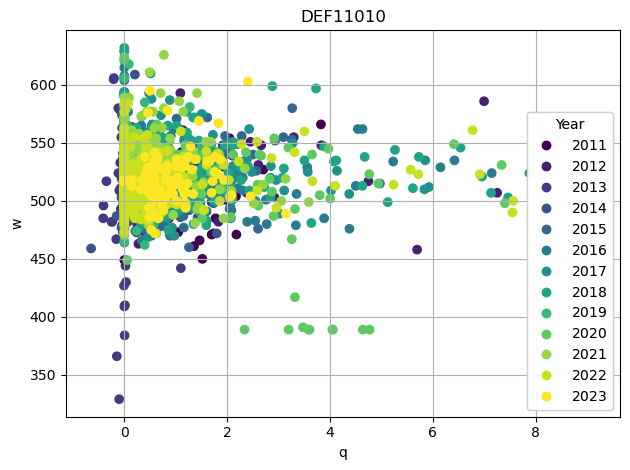

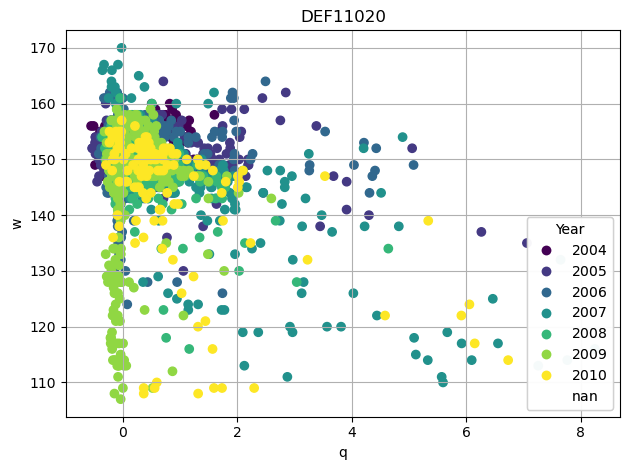

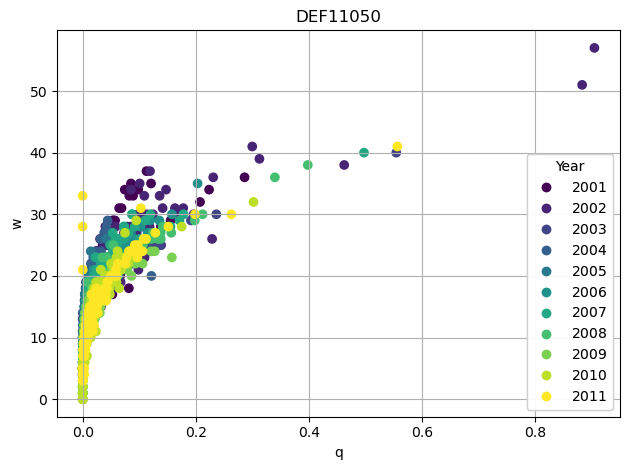

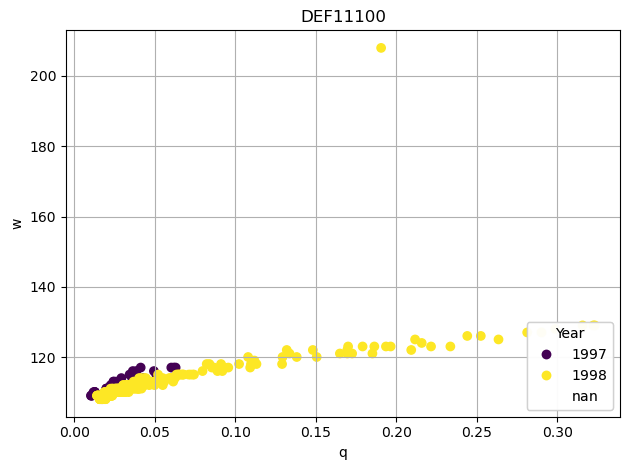

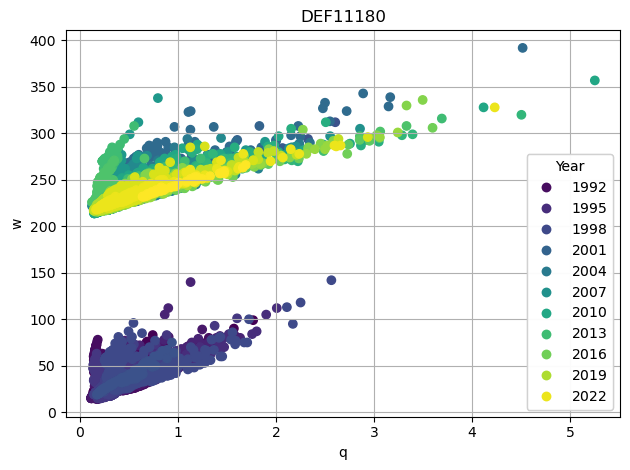

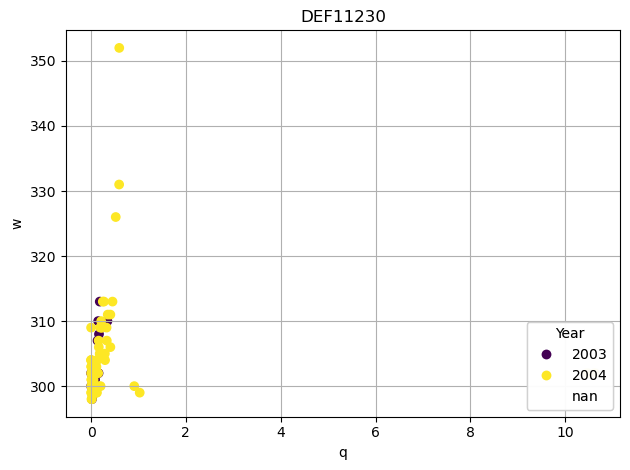

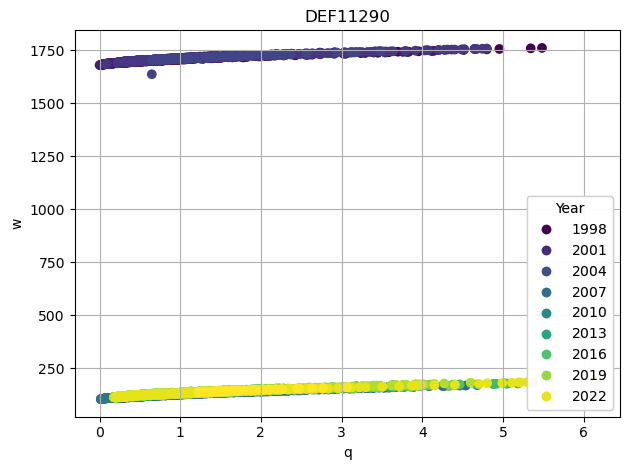

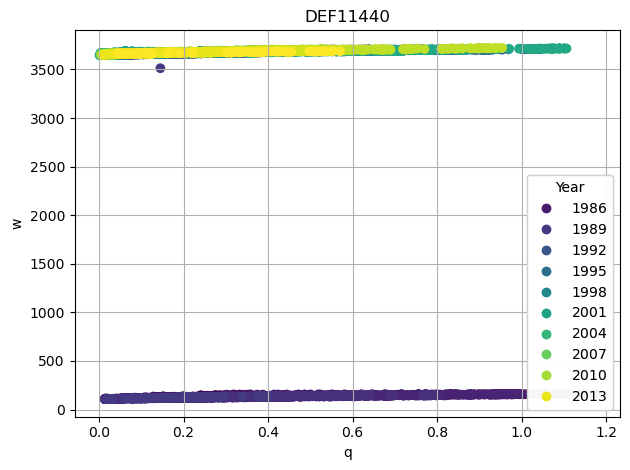

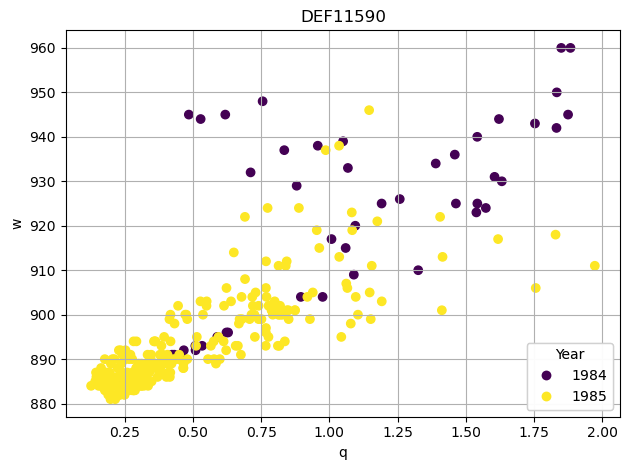

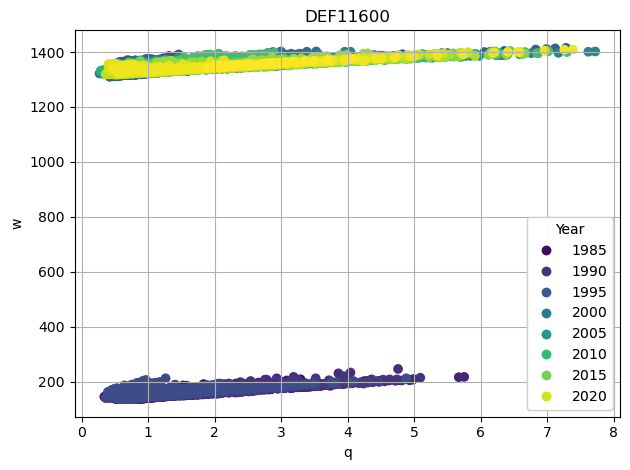

In [82]:
bl.generate_scatter_plots(nuts_ids= nuts_ids_scatter[7:], fmt = 'object')



In [ ]:
#Abschneiden bzw. schiften:
cut_off_dict = {
    'DEF10460' : '1996-05-01',
    'DEF10620' : '2003-04-01',
    'DEF10830' : '1986-04-01',
    'DEF10930' : '1989-08-01',
    'DEF11180' : '1999-07-15',
    'DEF11290' : '2003-04-03',
    'DEF11440' : '1989-05-02',
    'DEF11600' : '1993-11-01' }


In [151]:
bl.nuts_table[bl.nuts_table['nuts_id']== nuts_ids_scatter[16]]

,nuts_id,provider_id,path
160,DEF11600,114031,./DEF/DEF11600/DEF11600_data.csv


In [67]:
#df_whole[df_whole['sta_no_s']==station_id].sort_values(by='datum')#[760:]

114079

In [153]:
df_sc = bl.get_data(nuts_ids_scatter[16])
df_sc['date'] = df_sc.index
df_sc

,q,q_flag,w,w_flag,date
date,,,,,
1984-11-01,1.8413,False,175,True,1984-11-01
1984-11-02,1.7995,False,173,True,1984-11-02
1984-11-03,1.6842,False,170,True,1984-11-03
1984-11-04,1.5467,False,166,True,1984-11-04
1984-11-05,1.4880,False,165,True,1984-11-05
...,...,...,...,...,...
2023-04-11,NaN,NaN,1343,False,2023-04-11
2023-04-12,NaN,NaN,1344,False,2023-04-12
2023-04-13,NaN,NaN,1344,False,2023-04-13


,q,q_flag,w,w_flag,date
date,,,,,
1993-11-01,1.2005,True,1342,True,1993-11-01
1993-11-02,1.2369,True,1343,True,1993-11-02
1993-11-03,1.2325,True,1342,True,1993-11-03
1993-11-04,1.2524,True,1343,True,1993-11-04
1993-11-05,1.2546,True,1343,True,1993-11-05
...,...,...,...,...,...
2022-12-28,1.3146,True,1337,True,2022-12-28
2022-12-29,1.6887,True,1344,True,2022-12-29
2022-12-30,1.3785,True,1338,True,2022-12-30


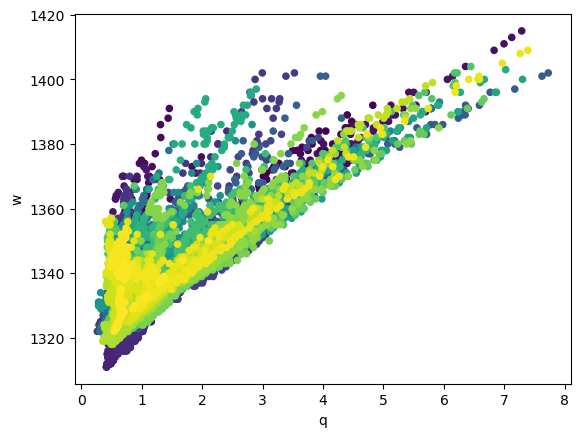

In [164]:
start = '1993-11-01'
end = '2023-01-01'

df_sc[pd.to_datetime(start):pd.to_datetime(end)].plot.scatter(x='q',y='w',c='date',colormap='viridis')
df_sc[pd.to_datetime(start):pd.to_datetime(end)]

In [149]:
df_sc[pd.to_datetime(start):pd.to_datetime(end)][df_sc[pd.to_datetime(start):pd.to_datetime(end)]['w'] < 3550]

,q,q_flag,w,w_flag,date
date,,,,,
1989-05-01,0.1452,True,3513,True,1989-05-01


In [63]:
int(nuts_map[nuts_map['nuts_id']==nuts_ids_scatter[6]].provider_id.values[0])

114079

In [ ]:
df_sc[pd.to_datetime(start):pd.to_datetime(end)].plot.scatter(x='q',y='w',c='date',colormap='viridis')

In [ ]:
df_sc[pd.to_datetime(start):pd.to_datetime(end)][['q','w']].plot()

In [ ]:
metadata[metadata['river'] == 'Mühlenau']

In [ ]:
df_whole[df_whole['sta_no_s'] == 114130]

In [ ]:
nuts_map.loc[nuts_map['provider_id'] == str(114082),'nuts_id'].iloc[0]

In [192]:
metadata[(metadata['x'] > 0)  & (metadata['y'] > 0)][['x','y']]

,x,y
0,32562584,6019011
1,32503881,6069898
2,32478768,6025071
3,32491930,6023940
4,32490061,6025357
...,...,...
770,32584558,6022619
771,32573621,5952781
772,32472688,6060763
773,32600025,5970053


<AxesSubplot:xlabel='x', ylabel='y'>

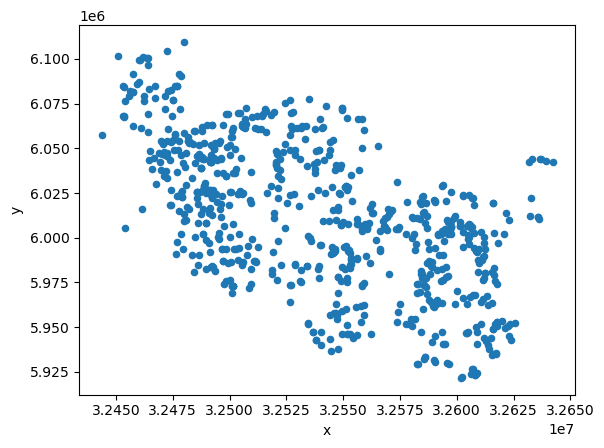

In [188]:
metadata[(metadata['x'] > 0)  & (metadata['y'] > 0)][['x','y']].plot(kind='scatter',x='x',y='y')

In [198]:
def calc_distance(lat1,lat2,lon1,lon2):
    if np.inf in [lat1,lat2,lon1,lon2]:
        return np.inf
    
    lat1 = radians(lat1)
    lat2 = radians(lat2)
    lon1 = radians(lon1)
    lon2 = radians(lon2)

    dlat = lat1 - lat2    
    dlon = lon1 - lon2
    
    
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    distance = 6373.0 * c
    return distance

In [202]:
def calc_distance2(lat1,lon1,lat2,lon2):
    if np.inf in [lat1,lat2,lon1,lon2]:
        return np.inf
    
    lat1 = radians(lat1)
    lat2 = radians(lat2)
    lon1 = radians(lon1)
    lon2 = radians(lon2)

    dlat = lat1 - lat2    
    dlon = lon1 - lon2
    
    
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    distance = 6373.0 * c
    print(f"{distance:.1f}km")
    #return distance

In [203]:
calc_distance2(50.13,8.66,48.79,9.17)


153.5km


In [36]:
threshold = 0.5
for j, row in metadata.iterrows():
    for k, row2 in metadata[j+1:].iterrows():
        distance = calc_distance(row['lat'],row2['lat'],row['lon'],row2['lon'])
        if distance < threshold and (row2['id'] in df_missing['id'].values):
            print(f"{distance:.4f}km")
            print(row['id'],row['gauge'],row['lat'],row['lon'])
            print(row2['id'],row2['gauge'],row2['lat'],row2['lon'])
            print('####################')

0.1785km
114634 Bäk 53.71015451254486 10.783491997705417
114077 BäkUP 53.70870657514928 10.782324630526915
####################
0.3407km
114427 BäkOP 53.71168179169125 10.783556612188436
114077 BäkUP 53.70870657514928 10.782324630526915
####################
0.3849km
114022 Dörpum 54.6539907449992 9.009299754779784
114475 DörpumerMergelkuhlen 54.65182444490014 9.013964389046333
####################
0.0524km
114082 Farchau 53.67751421867664 10.756039672707058
114635 Farchau2 53.67774680304572 10.7567306974423
####################
0.3466km
114622 FehmarnSchöpfwerkTeichhof 54.52753531138767 11.111006169965464
114624 FehmarnZufahrtTeichhof 54.52646730686811 11.116051093749917
####################
0.2008km
114334 GrWittensee 54.40304269171917 9.783959373799904
114633 GrWittenseeRetentionsbecken 54.40397813022008 9.786611579055052
####################
0.2028km
114636 GrWittenseeMühlenbek 54.4030519781449 9.783913335031846
114633 GrWittenseeRetentionsbecken 54.40397813022008 9.786611579055052


inf

In [ ]:
nuts_map[nuts_map['nuts_id'] == 'DEF17090']

In [ ]:
# set to true, if new output data was added (ie. rainfall)
REPLACE = True
with Bundesland('Schleswig-Holstein') as bl:
    with warnings.catch_warnings(record=True) as warn:
        bl.generate_reports(nuts_ids='DEF17090', fmt='html', if_exists='replace' if REPLACE else 'omit')


        if len(warn) > 0:
            print(f"There were {len(warn)} warnings (missing data files).")